# Global Terrorism Database -- Month Classifier

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
import seaborn as sn
import tempfile
import matplotlib.pylab as plt
import os
#if not os.path.isdir('figures'):
    #os.makedirs('figures')

In [ ]:
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

### Read in cleaned data
The datafile "gtdb(clean).csv" is put in the same folder as this file. 

In [ ]:
df = pd.read_csv('gtdb(clean).csv', encoding = "ISO-8859-1") #read in cleaned dataset 

In [ ]:
encoder = LabelEncoder() #use LabelEncoder to change text variables to numbers
df.head()

,Unnamed: 0,iyear,imonth,country,country_txt,region,provstate,city,location,summary,success,suicide,attacktype1_txt,targtype1_txt
0,0,1970,7.0,58,Dominican Republic,2,NaN,Santo Domingo,NaN,NaN,1,0,Assassination,Private Citizens & Property
1,3,1970,1.0,78,Greece,8,Attica,Athens,NaN,NaN,1,0,Bombing/Explosion,Government (Diplomatic)
2,4,1970,1.0,101,Japan,4,Fukouka,Fukouka,NaN,NaN,1,0,Facility/Infrastructure Attack,Government (Diplomatic)
3,5,1970,1.0,217,United States,1,Illinois,Cairo,NaN,1/1/1970: Unknown African American assailants ...,1,0,Armed Assault,Police
4,6,1970,1.0,218,Uruguay,3,Montevideo,Montevideo,NaN,NaN,0,0,Assassination,Police


In [ ]:
encoder.fit(df['city'])
df['city'] = encoder.transform(df['city'])
encoder.fit(df['attacktype1_txt'])
df['attacktype1_txt'] = encoder.transform(df['attacktype1_txt'])
encoder.fit(df['targtype1_txt'])
df['targtype1_txt'] = encoder.transform(df['targtype1_txt'])
df.head() #converted all relevant text variables to numbers

,Unnamed: 0,iyear,imonth,country,country_txt,region,provstate,city,location,summary,success,suicide,attacktype1_txt,targtype1_txt
0,0,1970,7.0,58,Dominican Republic,2,NaN,26427,NaN,NaN,1,0,1,13
1,3,1970,1.0,78,Greece,8,Attica,2224,NaN,NaN,1,0,2,5
2,4,1970,1.0,101,Japan,4,Fukouka,10021,NaN,NaN,1,0,3,5
3,5,1970,1.0,217,United States,1,Illinois,5624,NaN,1/1/1970: Unknown African American assailants ...,1,0,0,12
4,6,1970,1.0,218,Uruguay,3,Montevideo,20153,NaN,NaN,0,0,1,12


### Select input attributes
Drop columns with missing data, as it does not contribute to the prediction.

In [ ]:
new_df = df[["iyear", 'imonth', 'country','region','city','success','suicide', 'attacktype1_txt', 'targtype1_txt']].copy()
print(new_df.head())
new_df = new_df.values

   iyear  imonth  country  ...  suicide  attacktype1_txt  targtype1_txt
0   1970     7.0       58  ...        0                1             13
1   1970     1.0       78  ...        0                2              5
2   1970     1.0      101  ...        0                3              5
3   1970     1.0      217  ...        0                0             12
4   1970     1.0      218  ...        0                1             12

[5 rows x 9 columns]


### Reduce size of dataset
In order to boost the performance, 1000 records in taken for each class (Jan, Feb, ..., Dec). This ensures the balance among classes.

In [ ]:
df['imonth'].value_counts() #get total count of each month to compare accuracy.

5.0     14673
7.0     14266
8.0     13847
10.0    13782
3.0     13473
6.0     13458
4.0     13425
1.0     13200
11.0    12923
9.0     12516
2.0     12198
12.0    11909
Name: imonth, dtype: int64

In [ ]:
ind = np.argsort( new_df[:,1] )
new_df = new_df[ind]
sets = new_df[:, 0:9]
# Take 1000 records from every month
sets = np.delete(sets, slice(1000,13200), 0)
sets = np.delete(sets, slice(2000,13198), 0)
sets = np.delete(sets, slice(3000,15473), 0)
sets = np.delete(sets, slice(4000,16425), 0)
sets = np.delete(sets, slice(5000,18673), 0)
sets = np.delete(sets, slice(6000,18458), 0)
sets = np.delete(sets, slice(7000,20266), 0)
sets = np.delete(sets, slice(8000,20847), 0)
sets = np.delete(sets, slice(9000,20516), 0)
sets = np.delete(sets, slice(10000,22782), 0)
sets = np.delete(sets, slice(11000,22923), 0)
sets = np.delete(sets, slice(12000,22909), 0)
X = np.delete(sets, 1, 1) 
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
y = sets[:, 1].astype(int)
y = y-1


### Split train data and test data
70% of the data is used as training data, 24% as the test data, and 6% as the validation data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)  #split into training data and test data
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=21) #create validation data set

### Construct the model
A deep convolutional neural network with 5 hidden layers are used. The number of hidden layers and nodes are determined with advice online and refined with several testings.

In [ ]:
model = Sequential([
    Flatten(input_shape=(1, 8)),  # input layer
    Dense(640, activation='relu'),
    Dense(480, activation='relu'),
    Dense(320, activation='relu'),
    Dense(160, activation='relu'),
    Dense(80, activation='relu'),# hidden layers
    Dense(12, activation='softmax') # output layer
])

### Compile the model
In order to achieve a higher test accuracy and fast training process, Adam optimizer with learning rate decay is adopted. The values of learning rate, decay step and decay rate are adopted from example model, and refined to fit this data after nultiple rounds of testing.

In [ ]:
initial_learning_rate = 0.003
decay_steps = 1000 
decay_rate = 0.9
lr = optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False, name=None
)
optimizer = optimizers.Adam(learning_rate = lr, epsilon = 0.1)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']) #initial model, no biases, no normalization

### Fit the model on train data
The batch size of 2000 is chosen as the size of train data is large. This speeds up the training as compared to mini-batch of size 32 or 64. 
Initially, the number of epochs were 10000, then it was changed to 1000 as it was observed that the accuracies converge around there.

In [ ]:
history = model.fit(X_train, y_train,epochs=1000, batch_size=2000, verbose=1, validation_data = (X_val, y_val))

Epoch 1/1000
6/6 [==============================] - 0s 25ms/step - loss: 2.4863 - accuracy: 0.0825 - val_loss: 2.4860 - val_accuracy: 0.0667
Epoch 2/1000
6/6 [==============================] - 0s 6ms/step - loss: 2.4862 - accuracy: 0.0825 - val_loss: 2.4858 - val_accuracy: 0.0667
Epoch 3/1000
6/6 [==============================] - 0s 6ms/step - loss: 2.4861 - accuracy: 0.0827 - val_loss: 2.4857 - val_accuracy: 0.0667
Epoch 4/1000
6/6 [==============================] - 0s 7ms/step - loss: 2.4860 - accuracy: 0.0831 - val_loss: 2.4855 - val_accuracy: 0.0667
Epoch 5/1000
6/6 [==============================] - 0s 6ms/step - loss: 2.4858 - accuracy: 0.0834 - val_loss: 2.4853 - val_accuracy: 0.0625
Epoch 6/1000
6/6 [==============================] - 0s 7ms/step - loss: 2.4857 - accuracy: 0.0835 - val_loss: 2.4851 - val_accuracy: 0.0625
Epoch 7/1000
6/6 [==============================] - 0s 7ms/step - loss: 2.4855 - accuracy: 0.0832 - val_loss: 2.4848 - val_accuracy: 0.0583
Epoch 8/1000
6/6 [=

### Evaluate the model on test data

In [ ]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=1) 

print('Test accuracy:', test_acc)

30/30 [==============================] - 0s 2ms/step - loss: 1.3171 - accuracy: 0.5240
Test accuracy: 0.5239583253860474


In [ ]:
modelTrain = model.predict(X_train, batch_size = 2000, verbose = 2)
cmt = confusion_matrix(y_train, modelTrain.argmax(axis = -1))

6/6 - 0s


In [ ]:
modelPredict = model.predict(X_test, batch_size = 10, verbose = 2)
cm = confusion_matrix(y_test, modelPredict.argmax(axis = -1))

96/96 - 0s


### Plot accuracy and loss graphs

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


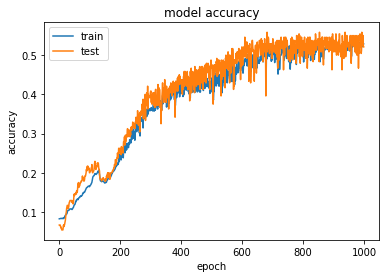

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() #plot accuracy graph over time

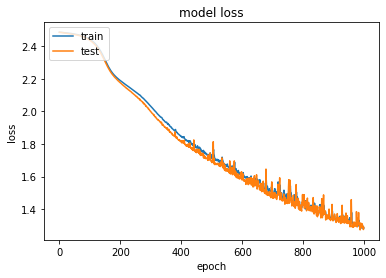

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() #plot loss curve

### Plot confusion matrics

AxesSubplot(0.125,0.125;0.62x0.755)


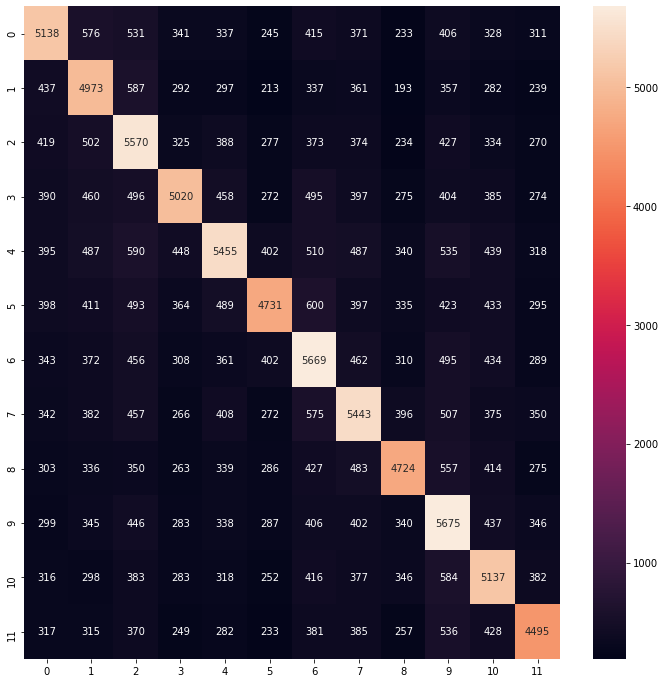

In [ ]:
#Plot training heatmap (these are the heatmaps after training for 10000 epochs)
plt.figure(figsize = (12,12))
month_plot_train = sn.heatmap(cmt,annot=True, annot_kws={"size": 10},fmt='d')
print(month_plot_train)
month_plot_train.figure.savefig("Month Train Heatmap.png") 

AxesSubplot(0.125,0.125;0.62x0.755)


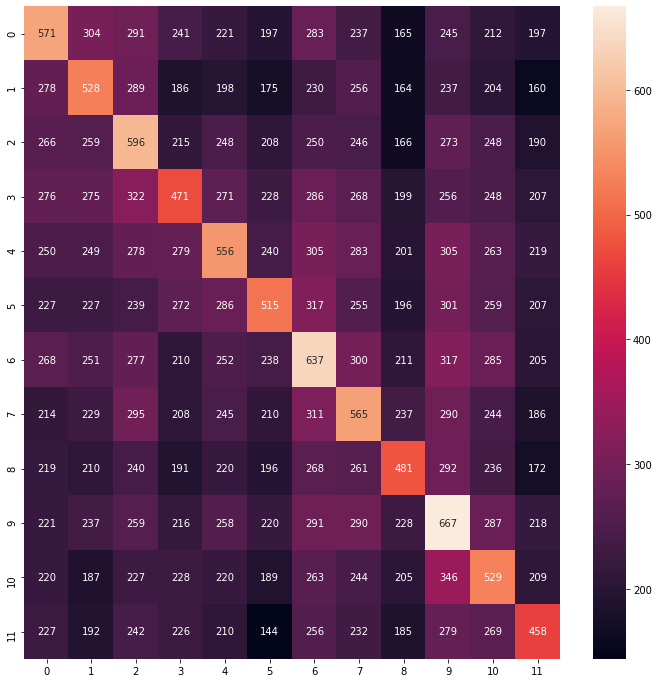

In [ ]:
#Plot testing heatmap
plt.figure(figsize = (12,12))
month_plot = sn.heatmap(cm,annot=True, annot_kws={"size": 10},fmt='d')
print(month_plot)
month_plot.figure.savefig("Month Prediction Heatmap.png") 